# Explainer Notebook for Warcraft Major Character Analysis

Resulting website: [youngpenguin.github.io/WOW/](https://youngpenguin.github.io/WOW/)

Throwback to YouTube video: [Social Graphs Project A](https://www.youtube.com/watch?v=JJx5f5nSYfs&ab_channel=SimonPedersen)

GitHub repos: 
- Analysis repo [github.com/simonamtoft/warcraft-major-character-analysis](https://github.com/simonamtoft/warcraft-major-character-analysis)
- Website repo [github.com/YoungPenguin/WOW](https://youngpenguin.github.io/WOW/)

### Imports and Data Loading

In [1]:
import re
import os
import nltk
import json
import flair
import pickle
import ciso8601
import powerlaw
import community
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sns.set()

# import home-made stuff
import config
from sentiment_helper import plot_timeseries, get_ts, plot_comments_dist, \
    standardize_comment, plot_quote_dist, get_specific_comment
from graph_helpers import print_all_degree_stats, get_nodes_from_attr, \
    compute_centrality_faction, compute_centrality_gender, compute_centrality_status
from text_helpers import get_paths, disp_wordcloud

## 1. Motivation
- What is your dataset?
- Why did you choose this/these particular dataset(s)?
- What was your goal for the end user's experience?

The motivation for this project is to explore characteristics of the main characters in Warcraft, since many people have played the game, but without paying attention to the character traits and stories of the different characters. In the Warcraft universe, the plot revolves around two competing factions, the Horde and the Alliance, which are in constant conflict with eachother. We would thus like to compare how these factions differ. Moreover, we would like to see whether the users experience matches up with the traits of these characters, evaluated by examining user comments.

Our dataset consists of data from [https://wowpedia.fandom.com/](https://wowpedia.fandom.com/), and [https://www.wowhead.com/](https://www.wowhead.com/). Since the Warcraft universe is rather large, we've chosen to investigate a subset of these, by analysing the network of [the Major Characters in Warcraft wowpedia](https://wowpedia.fandom.com/wiki/Major_characters), along with their corresponding threads on [wowhead](https://www.wowhead.com/), which contains a lot of user comments. 

The goal of the end user's experience is for the user to be able to easily see the characteristics of some of the main groupings of Warcraft characters, by evaluating their connections to eachother and investigating the most describing words for groups of characters.
For maximum enjoyment, the desired website should be heavily encourage user interactions with the different plots and data tables, along with being enjoyable on any device, be it a home computer with a large monitior, or a small smart phone with a tilted screen!

## 2. Basic Statistics
Let's understand the dataset better
- Write about your choices in data cleaning and preprocessing
- Write a short section that discusses the dataset stats

In order to perform text and network analysis on the chosen data, a lot of data cleaning and preprocessing had to take place.

The primary tools that have been used to get the data are 
- `BeautifulSoup` and `requests` for wowhead comments (see `download_character_comments.py`)
- `urllib` for wowpedia pages (see `api.py`)

For the wowpedia pages, both the raw and clean pages have been downloaded (see `/data/wow_chars/` and `/data/wow_chars_clean/`), while for wowhead the comments were downloaded and stored along with all its metadata, and later cleaned. For cleaning and preprocessing of the data, the primary tools that have been used are the text analysis library `nltk` and the regular expressions library `re`. The cleaning, preprocessing and downloading from websites will be described more in-depth in the next section under Tool 1.

The data can be split into the following subdivisions:
1. Wowhead comments (~700 files, 31MB)
    1. Raw .njson files containing every comment on the wowhead character pages along with some metadata, like dates. (see `download_character_comments.py`)
        1. Note: For some characters, multiple pages are present in which we got comments from all of them.
    2. Processed .txt files, which consists of the comments from the raw files without any metadata (see `comments_clean.py`)
    3. Words .txt files, which based on the processed .txt files have had stopwords removed, text has been tokenized and every word has been lemmatized (see `comments_to_words.py`)
2. Wowpedia pages (~1000 files, 19MB)
    1. Raw .txt files containing the entire wowpedia character page (see `download_character_pages.py`)
    2. Clean .txt files containing the clean version of the wowpedia character page (see `download_character_pages_clean.py`)
    3. Quotes .txt files, which based on the raw .txt files consists of all the quotes from the characters quote section on its wowpedia page (see `extract_character_quotes.py`)
    4. Words .txt files, which based on the clean .txt files have had stopwords removed, text has been tokenized and every word has been lemmatized (see `pages_to_words.py`)

The resulting dataset consists of ~1700 files (totalling 50 MB).

The resulting network graph has 261 nodes, index by the character name, and 4009 edges, where each node has the following four attributes `faction`, `gender`, `race` and `status` (see `Graph Analysis.ipynb`). The creation of the graph will be described in tool 1.

## 3. Tools, Theory and Analysis
Describe the process of theory to insight
- Talk about how you've worked with text, including regular expressions, unicode, etc.
- Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
- How did you use the tools to understand your dataset?

### Tool 1: Downloading and Cleaning Data

#### Downloading Raw and Clean Wowpedia pages
In order to start off the project, the first thing that had to be done was to download all the raw wowpedia pages for each of the [major characters](https://wowpedia.fandom.com/wiki/Major_characters). In order to extract links from the wowpedia pages to create a network graph, a single regex was constructed, which finds links from double brackets: `\[\[(.*?)(?:[\|#].*?)?\]\]`. Additionally, python functions were made to generate queries and getting responses from webpages using said queries (see `api.py`). In this process, it is important to remember to keep special characters when constructing the query, which was done with `quote_plus` from `urllib`, and also to decode the response from the webpage with `utf-8` format and make sure it is json serializable with `json.loads`. 

Then, we could create a list of the names of each of the major characters by extracing the links from the [major characters page](https://wowpedia.fandom.com/wiki/Major_characters), which was done by first querying the webpage with `urllib.request` and then extracting the page content from the response. In order to extract the character names from the raw wowpedia text response, it was first cleaned by:
1. removing everything before the list of characters by splitting on `"==[[Races]]=="`
2. removing all headers with `re.sub(r'==(.+)==', '', txt)` 
3. removing last part of page that links to another collection of main characters by splitting on `'{{Main characters}}'`

Then, the character names were found by looking for all linking patterns (defined earlier) remaining on the page. For each of these characters, both their raw and clean wowpedia pages were downloaded (see `download_character_pages.py` and `download_character_pages_clean.py`). From the clean pages, we additionally removed headers and excess newline and space chars before storing them. 

Note: We've avoided to add the downloading and preprocessing code directly into this notebook since some of it took very long to run. All the preprocessed data along with the raw data can be found on the website as a zip file.

#### Pre-processing the Wowpedia Pages
The downloaded raw wowpedia pages (`/data/wow_chars/`) was used for two different purposes.
1. To create the network graph
    - Consisting of attributes `gender`, `race`, `faction` and `status`.
        - The attributes were extracted from the pages by finding the Npcbox with `wikitextparser`.
    - Each node is a character, indexed by the name.
    - Edges are directed edges describing links between wowpedia character pages.
        - A directed edge was added if one characters page linked to another. 
        - Used the linking pattern with double brackets described earlier.
    - See `create_wow_graph.py`.  
2. Extracting character quotes for sentiment analysis
    - Some character pages has a quotes section, listing quotes from the pages character.
    - The quotes were extracted by:
        1. Extracting the quotes section 
            - First everything before the quotes section was removed by finding the quotes header with the regex `[q|Q]uotes ?==`
                - It searches for a header that containes the word quotes at the end (some quote headers had another word before.)
            - Secondly, the next section was found and removed with the following regex `\s==([^=]+)==\s`, which finds a header.
            - Note there were multiple levels of headers, e.g. with three equal signs, which are subheaders we want to keep in the quotes section and thus the regex excludes those.
        2. Removing gallary section.
            - Contained in some quotes sections.
            - Removed by the regex `<gallery>[^><]+<\/gallery>`
        3. Removing references, could be images etc., with three different regex:
            - `<ref>[^<]+<\/ref>`
            - `<ref name=[\w\d \-"\'().,]+>.+<\/ref>`
            - `<ref name=[\w\d \-"\'().,]+\/>`
        4. Headers and section headers are removed by the following two regex:
            - `==(.+)==`, finds headers which consists of two equal signs on every side and text in between.
            - `\{\{\w+\-section\}\}`, finds sub quote sections which are in double curly brackets and ends with '-section'.
        5. Replace markdown style line breaks, `<br>`, with standard line breaks: `re.sub('</?br>', '\n', quotes)`.
        6. Remove "{{sic}}" with the regex `\{\{sic\}\}`.
        7. Remove patch information
            - `\(Patch \d(.\d)+\)`, finds a parenthesis containing the word Patch and patch number with varying number of digits e.g. "(Patch 4.2.1)".
            - `\(Removed in ''Patch \d.\d.\d\w?''\)`, finds a parenthesis describing something that was removed during a specific patch, e.g. "(Removed in ''Patch 2.1.2a'')".
        8. Extract text from an url link and replace it 
            - regex: `\[(https?:\/\/[\w\/.]+)(.+)\]`
            - replace entire found string only by the second group in the regex `(.+)`.
        9. Remove the chars `*` and `:` from the text
        10. Remove linking patterns in double curly brackets
            - regex: `\{\{[M|m]ain\|([\w ()\/\'\!\,\?\-\.]+)(?:#[\w \'\-]+)?\}\}`
        11. Remove markdown in-line comments with style `<!-- text -->`.
            - regex: `<!--[^<]+-->`
        12. Extract words from double bracket linkings
            - regex: `\[\[([\w '\(\)\-,.\?\!#]+\|(?:\w+\|)?)?([\w\d ',.\-\?()\!]+)\]\]`
            - The regex matches the linking pattern and hereafter the match is substituted by the last group of the regex `([\w\d ',.\-\?()\!]+)`.
        13. Read the remaining text line by line, since there is some weird formatting that is easilier handled this way.
            1. Remove lines containing ".jpg" or ".png", since it is residue from non-perfect regex.
            2. Extract quotes from text with character name with format "{{text|--|person|quote}}"
                - regex: `\{\{(?:[t|T]ext)\|(?:[s|S]ay|[y|Y]ell|[w|W]hisper)\|([^|]+)\|([^\|\{]+)\}\}`
                - The first capture group will be the character, and the second will be the quote. 
                - The character could be a link to a character, and if so extract the character name from the link.
                    - regex: `\{\{(npc|NPC)\|\|([\w \-\']+)(\|\|[\w \-\']+)?\}\}` 
                    - replace whatever is found by the regex, with the last of the groups.
                - If the resulting character is not the same character as we are extracting quotes for, discard the line, by setting it to an empty string.
            3. Extract quotes from pattern "{{--|person|quote}}"
                - regex: `\{\{(npc|NPC)\|\|([\w \-\']+)(\|\|[\w \-\']+)?\}\}`
                - If the resulting character is not the same character as we are extracting quotes for, discard the line, by setting it to an empty string.
            4. Extract quote from a text quote pattern {{text|--|quote}}
                - regex: `\{\{(?:text|Text)\|(?:[s|S]ay|[y|Y]ell|[w|W]hisper)\|(.+)\}\}`
                - simply replace the line by the last group of the regex that captures the quote `(.+)`.
            5. Find characters in quotations "'''character name'''"
                - regex: `\'\'\'([\w ]+)\'\'\'`
                - If the resulting character is not the same character as we are extracting quotes for, discard the line, by setting it to an empty string, otherwise replace the found regex and keep rest of line.
            6. Extract quote from gossip pattern "{{gossip|quote}}"
                - regex: `\{\{([G|g]ossip\|)(.+)\}\}`
                - replace the regex matching with just the last group.
            7. Remove excess spaces from the line
            8. Remove references to unit quotes
            9. Remove residue quote headers
            10. Handle nested links
                - regex: `\{\{([^|{]+\|(?:[^|]+\|)?)(.+)\}\}`
                - Again replace by last group of regex if found.
            11. Remove actions with pattern `<action>`
                - `re.sub(r'<[\w .\/\',\?]+>', '', line)`
            12. Remove apostrophes that appear together in groups of 2 or larger.
                - `re.sub(r"''+", '', line)`
            13. Remove everything in double curly brackets {{}} or parenthesis ()
                - After all the other cleaning, this will not be quotes.
                - `re.sub(r'\{\{[^\{\}]+\}\}', " ", line)`
                - `re.sub(r'\([^\(\)]+\)', " ", line)`
            14. Remove residue from a non-perfect link regex, where line starts with "word="
                - `re.sub(r'\w+=', ' ', line)`
            15. Remove specific characters at the end
                - Includes: `", “, —, [, ], ;, -`
            16. Remove excess spaces: `re.sub(r'[ ]+', ' ', lines).strip()`
    - See `extract_character_quotes.py`.


The downloaded clean wowpedia pages (`/data/wow_chars_clean/`) were further processed in order to later perform text analysis on.
- For each clean character page text file, the following processing was done
    1. Clean character file was read in as text using encoding `utf-8`.
    2. Small cleaning was done by removing patch information
        - regex: `Patch \d.\d.\d \(\d\d\d\d\-\d\d\-\d\d\)\:`
    3. Character names were stripped from the text (not including nicknames).
    4. Remove apostrophes, since a lot of specific Warcraft words contain these, and we want to keep the meaning of those words.
    4. Entire text was turned to lowercase with `.lower()`.
    4. Text was turned into tokens with the `WordPunctTokenizer` from `nltk`. 
    5. Tokens that are stopwords and non-word tokens were removed, resulting in a list of words.
    6. Every word were lemmatized using the `WordNetLemmatizer` from `nltk`.
    7. Finally, the words were written to a text file using encoding `utf-8`. 
- See `pages_to_words.py`.

#### Wowhead comments
The goal here was to find some augmenting data from Wowhead users for the major characters we extracted from wowpedia. It became apparent that multiple NPCs exist in-game for every character (for technical reasons, etc.), and as a consequence of this, there are multiple Wowhead NPC pages for every character.

By hopping around on Wowhead for a bit, we discovered that they have a search page for NPCs which allowed filtering. Thus, we quickly set up a procedure for calling this endpoint with the filter `Has comments` set to `Yes`. Additionally, the search page seemed to fuzzily match the names from the Wikipage characters, but it was not completely resilient to discrepancies (e.g. `Thoras Trollbane` will find some pages, but `Thoras Trollbaen` will not. The search results were embedded in the page as `<div>` elements with a certain *id* attribute. This is where `beautifulsoup` came in handy. It enables you to parse HTML text data into a virtual DOM structure, which allows for more resilient scraping than pure regular expressions can provide. After some DOM and text manipulation, the links to the NPC pages are now extracted for every character.

For every NPC page on Wowhead, we needed to scrape the user comments. Luckily, these seemed to be embedded in the NPC pages themselves in a certain `<script>` element. Conveniently, the comment data is already formatted as JSON and can be directly extracted and saved. We save the comments a `.njson` format, which is simply newline-delimited JSON (i.e. every line of the file parses as its own JSON object).

The entire procedure of taking Wikipage character names and outputting Wowhead comments is defined in the script `download_character_comments.py`. We also added a timeout to the script to avoid making too many requests to Wowhead and getting blacklisted.


The comment text data needed to be cleaned before we could use it for analysis, however. Thus, we created a few regular expressions to help clean up the comment texts:
* `re.sub(r"\[.+?\]", "", t)`
    * For instance, the comments would often include hyperlinks to other Wowhead pages, e.g. `"You need to complete [url=http://www.wowhead.com/?quest=10588]Cipher of Damnation[/url] first."`. This regular expression finds pairs of brackets `[` and `]` with 1 or more character between them, and matches them lazily (i.e. as few chars as possible). Thus, the result of the example would be  `"You need to complete Cipher of Damnation first."`

* `re.sub(r"(\\r|\\n|\\t)+", " ", t)`
    * Users also seemed to write out their comments using several lines. This means that a lot of carriage returns, newlines were present in the raw texts, e.g. `"I say this guy becomes boss lvl.\r\n\r\nAfter experiencing the ..."`. These sequences of spacing characters could be replaced with a simple space character. As such, we created a regular expression which finds all sequences of 1 or more consecutive \r, \n or \t characters and replaces them with a single space character.
    
* `re.findall(r"(.+?(?:[!.?]+|$))(?:\s|$)", t)`
    * Depending on how the text is to be analyzed, it can be useful to split a text blob into its individual sentences. The above expression lazily finds all sequences of characters that are followed by 1 or more sentence delimiter characters (i.e. . or !) or the end of sequence, which are subsequently followed by either a space or the end of the sequence. It seems to work better for our use case than `sent_tokenize` from the `nltk` package.
    

In [2]:
# Load resulting graphs
G = nx.read_gexf('./store/G_wow.gexf')
Gcc = nx.read_gexf('./store/Gcc_wow.gexf')

# get the undirected version of the GCC
Gcc_u = Gcc.to_undirected().copy()

# read in the resulting character DataFrame
df = pd.read_csv(config.PATH_RES + 'df_chars.csv')

# create a smaller version of the DataFrame 
# only containing the characters that had Wowhead comments
# used when doing sentiment analysis and sometimes when directly comparing wowhead and wowpedia
chars_with_comments = [
    path.split('\\')[-1].replace('.njson', '') 
    for path in glob('./data/char_comments/*.njson')
]
df_comments = df[df['Name'].apply(lambda n: n in chars_with_comments)]

# get node and edge lists of Gcc
node_list = np.array(list(Gcc.nodes))
edge_list = np.array(list(Gcc.edges))

# print quick info
N = len(node_list)
print(f'\t\tG\tGcc')
print(f"# of nodes:\t{len(list(G.nodes))}\t{N}")
print(f"# of links:\t{len(list(G.edges))}\t{len(edge_list)}")

		G	Gcc
# of nodes:	264	261
# of links:	4010	4009


Lets load in some of the processed text as well.

In [3]:
# word and clean files for wowpedia character pages
files = [config.PATH_WORDS + n.replace(' ', '_') + '.txt' for n in df['Name'].values]
c_words_wiki = nltk.corpus.PlaintextCorpusReader('', files)
t_words_wiki = nltk.Text(c_words_wiki.words())
files = [config.PATH_CLEAN + n.replace(' ', '_') + '.txt' for n in df['Name'].values]
c_clean_wiki = nltk.corpus.PlaintextCorpusReader('', files)

# word files for wowhead user comments
files = [config.PATH_COMMENTS_WORDS + n.replace(' ', '_') + '.txt' for n in df_comments['Name'].values]
c_words_comments = nltk.corpus.PlaintextCorpusReader('', files)
t_words_comments = nltk.Text(c_words_wiki.words())

### Tool 2: Network Analysis

#### Network Visualizations, Character Connections and Node Attributes
We want to investigate how the different characters connect with each other, and which of these characters play a major role in Warcraft by examining how important they are to the network.

After creating the Warcraft network, we have visualized it using the ForceAtlas algorithm, while coloring nodes according to their `Faction` attribute (blue for Alliance, red for Horde and gray for Neutral). Additionally, nodes are scaled according to node degree and edges are colored according to the relationship between the connected nodes, such that the edge is blue between two alliance characters, red between two horde characters, green between a horde and alliance character and gray if one of the connecting nodes is a neutral node.

The resulting network has 261 nodes and 4009 links, where Thrall is the most connected character with an in-degree of 103 and out-degree of 84, which is the big red node in the bottom middel.

(we render a .png since the exact layout of the network changes a bit everytime it is run, and we want to keep it the same as the one on the website, if you want to run the network visualization code, uncomment the force atlas import below).

<img src="visualizations/network_static.png">

<!-- ![Network plot]() -->

In [4]:
# from fa2 import ForceAtlas2

In [5]:
# get nodes and edges with data
node_data = Gcc_u.nodes(data=True)
edge_data = Gcc_u.edges(data=True)

# determine node size in regards to degree of node
node_sizes = [2*v for v in dict(Gcc_u.degree).values()]

# create node color list depending on faction
node_colors = []
for _, attr in list(node_data):
    fac = attr['faction']
    if fac == 'Horde':
        node_colors.append('#FF3333')
    elif fac == 'Alliance':
        node_colors.append('#3399FF')
    else:
        node_colors.append('#A0A0A0')

# create edge color list depending on faction of the two connecting nodes
edge_colors = []
for n1, n2, _ in list(edge_data):
    f1 = node_data[n1]['faction']
    f2 = node_data[n2]['faction']

    if f1 == 'Alliance':
        if f2 == 'Alliance':
            edge_colors.append('#3399FF')
        elif f2 == 'Horde':
            edge_colors.append('#005700')
        else:
            edge_colors.append('#A0A0A0')
    elif f1 == 'Horde':
        if f2 == 'Alliance':
            edge_colors.append('#005700')
        elif f2 == 'Horde':
            edge_colors.append('#FF3333')
        else:
            edge_colors.append('#A0A0A0')
    else:
        edge_colors.append('#A0A0A0')

import sys
if 'ForceAtlas2' in sys.modules:
    # Setup FA2 w. parameters
    forceatlas2 = ForceAtlas2(
        # Behavior alternatives
        outboundAttractionDistribution=True,    # Dissuade hubs
        edgeWeightInfluence=1.0,

        # Performance
        jitterTolerance=1.0,  # Tolerance
        barnesHutOptimize=True,
        barnesHutTheta=1.2,

        # Tuning
        scalingRatio=2.0,
        strongGravityMode=True,
        gravity=1,

        # Log
        verbose=False
    )

    # compute node positions with the fa algorithm
    node_pos = forceatlas2.forceatlas2_networkx_layout(Gcc_u, pos=None, iterations=2000)

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(Gcc_u, node_pos, node_size=node_sizes, node_color=node_colors, alpha=0.75)
    nx.draw_networkx_edges(Gcc_u, node_pos, edge_color=edge_colors, alpha=0.2)
    plt.title('Warcraft Major Character Network')
    plt.axis('off')
    plt.show()

In order to see which characters are the most important out of the major characters, we inspect the top 5 most connected Alliance, Horde and Neutral characters.


<!-- |Alliance| (in, out) | |Horde | (in, out) ||Neutral | (in, out) |
|---------------------------|----:|-:|--------------------|----:|-:|--------------------|----:|
|	Jaina Proudmoore| 73, 72||	Thrall| 103, 84||	Sylvanas Windrunner| 79, 66|
|	Anduin Wrynn| 68, 63||	Lor'themar Theron| 37, 47||	Deathwing| 69, 53|
|	Varian Wrynn| 60, 66||	Baine Bloodhoof|44, 39||	Lich King| 76, 44|
|	Khadgar| 65, 55||	Vol'jin|42, 38||	Garrosh Hellscream| 63, 40|
|	Malfurion Stormrage| 54, 46||	Varok Saurfang|39, 36||	Arthas Menethil| 56, 41| -->

In [6]:
nd = Gcc.nodes(data=True)

# get top 5 characters based on total degree for each faction
print('Top 5 characters according to total degree for each faction')
for faction in df['Faction'].unique():
    top = [n for n, _  in sorted([
            (k, v) 
            for k, v in Gcc.degree 
            if nd[k]['faction'] == faction
        ], 
        key=lambda x: x[1], 
        reverse=True
    )[:5]]
    print(f'\t{faction} - ' + ', '.join(top))

Top 5 characters according to total degree for each faction
	Neutral - Sylvanas Windrunner, Deathwing, Lich King, Garrosh Hellscream, Arthas Menethil
	Horde - Thrall, Lor'themar Theron, Baine Bloodhoof, Vol'jin, Varok Saurfang
	Alliance - Jaina Proudmoore, Anduin Wrynn, Varian Wrynn, Khadgar, Malfurion Stormrage


As expected, the most connected alliance characters include the current and late kings of Stormwind (Anduin and Varian Wrynn). For the horde characters, we see Thrall, which has been the warchief of Orgrimmar and is probably one of the most known character in Warcraft, and Vol'jin who has also been the warchief of Orgrimmar. Finally, for the Neutral characters we see three end game bosses (Deathwing, Lich King, who was previously known as Arthas Menethil, and Garrosh Hellscream), along with one of the newest boss characters, Sylvanas Windrunner, who used to be a part of the horde faction.

Before we dive into analysing the network further, lets get a quick overview of the distribution of the different node attributes.

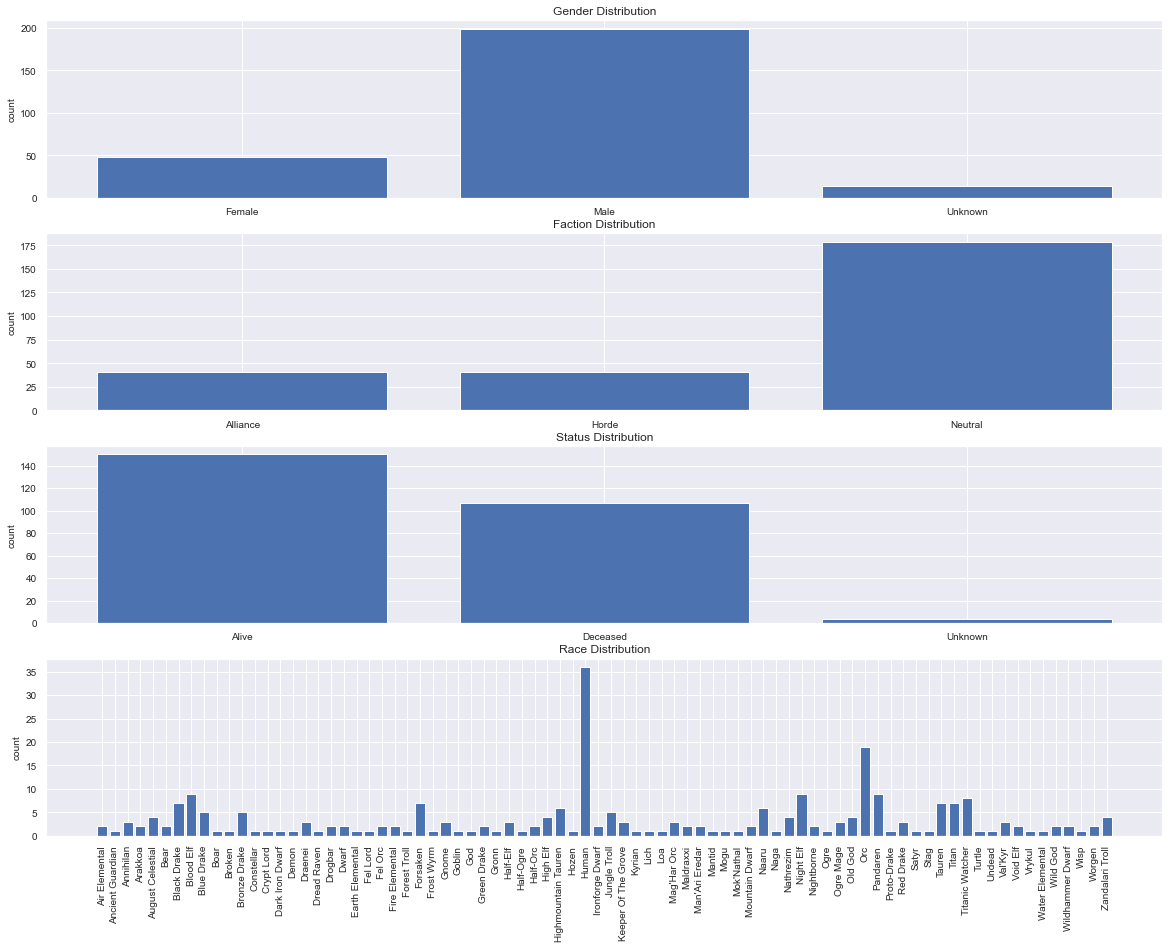

In [7]:
# get distribution for each of the four node attributes
attr_names = ['gender', 'faction', 'status', 'race']
f, ax = plt.subplots(len(attr_names), 1, figsize=(20, 15))
for i, aname in enumerate(attr_names):
    attr_list = np.array(list(nx.get_node_attributes(Gcc, aname).values()))
    attr_keys, attr_counts = np.unique(attr_list, return_counts=True)
    ax[i].set_title(f'{aname} distribution'.title(), fontsize=12)
    ax[i].bar(attr_keys, attr_counts)
    ax[i].set_ylabel('count', fontsize=10)

    if aname == 'race':
        xlabel_rotation = 90
    else:
        xlabel_rotation = 0
    plt.setp(ax[i].get_xticklabels(), fontsize=10, rotation=xlabel_rotation)
    plt.setp(ax[i].get_yticklabels(), fontsize=10)
plt.show()

From this attribute plot we see that genders, faction and status is nicely divided into a few groupings, however the race distribution is populated with a lot of different races with a few occurences apart from the main character races such as Human, Orc and Blood Elf.

In order to differentiate between the connectedness within the different communities of Alliance vs. Horde, we created subgraphs for each of these and calculated some basic degree stats, that is min, max, mean, median and mode for the in-, out- and total-degree of these subgraphs as displayed in the table below.

In [8]:
print("Degree stats for Entire Network")
print_all_degree_stats(Gcc)
attr_dict = {'faction': ['Horde', 'Alliance', 'Neutral']}
for attr_name, attrs in attr_dict.items():
    for attr in attrs:
        # print(f"\nNetwork for {attr}")
        nodes_ = get_nodes_from_attr(Gcc, attr_name, attr)
        G_sub = Gcc.subgraph(nodes_)
        print(f'\nDegree stats for {attr}')
        print_all_degree_stats(G_sub)

Degree stats for Entire Network
		min	max	mean	median	mode
In-degree	0	103	15.36	10.0	6
Out-degree	0	84	15.36	12.0	6
Total-degree	1	187	30.72	21.0	13

Degree stats for Horde
		min	max	mean	median	mode
In-degree	0	27	6.12	4.0	3
Out-degree	0	22	6.12	6.0	6
Total-degree	0	49	12.24	10.0	7

Degree stats for Alliance
		min	max	mean	median	mode
In-degree	0	27	9.37	9.0	5
Out-degree	0	24	9.37	9.0	4
Total-degree	0	51	18.73	18.0	6

Degree stats for Neutral
		min	max	mean	median	mode
In-degree	0	47	8.53	6.0	1
Out-degree	0	41	8.53	7.0	3
Total-degree	0	88	17.05	13.0	6


 From this, we can see that the Horde characters are more disconnected from eachother than the Alliance and Neutral characters (since the mean and median is lower for the horde characters). We note that the distribution of Horde and Alliance characters are the same, thus this cannot be the cause of the Horde degrees being generally lower.

#### Degree Distribution and Random Network Comparison
References: 
- [Network Science Section 3.3](http://networksciencebook.com/chapter/3#number-of-links)
- [Network Science: Section 4.7](http://networksciencebook.com/chapter/4#degree-exponent)

We would like to investigate whether the Warcraft Major Character network behaves as a real network, or follows the same kinds of distributions as a random network does. A random network has a binomial distribution, well approximated by a Poisson distribution, which fails to capture the degree distribution of real networks. In order to investigate this, we create two different random networks each with the same number of nodes as the Warcraft network. These random networks are created with `erdos_renyi_graph` from `networkx`, where we create one to compare with the in-degree distribtion and one to compare with the out-degree distribution, where their probability of connection between two nodes are calculated as `p = <k_in> / (N - 1)` and `p = <k_out> / (N - 1)` respectively (NS eq. 3.3). Additionally, we plot the in- vs. the out-degree of the Warcraft network in a scatter plot, to see their correlation.

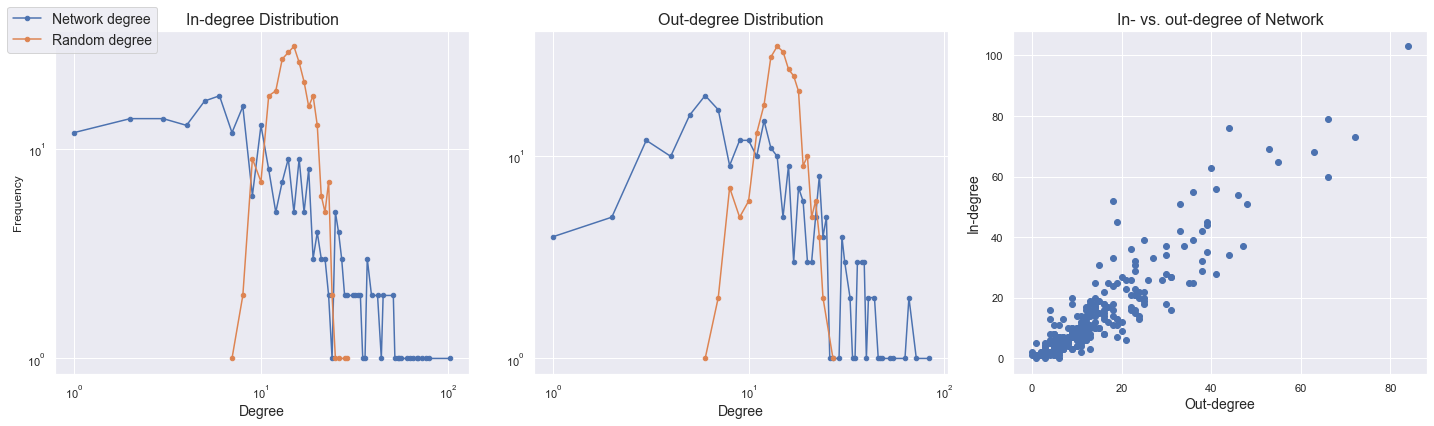

In [9]:
# Get arrays of total, out- and in-degrees
tot_deg = np.array([v for _, v in Gcc.degree])
out_deg = np.array([v for _, v in Gcc.out_degree])
in_deg = np.array([v for _, v in Gcc.in_degree])

# calculate probability of connection
p_out = out_deg.mean() / (N - 1)
p_in = in_deg.mean() / (N - 1)

# create random networks
G_rnd_out = nx.erdos_renyi_graph(n=N, p=p_out)
G_rnd_in = nx.erdos_renyi_graph(n=N, p=p_in)

# get degrees of random network
degs_rnd_out = np.array([v for _, v in G_rnd_out.degree()])
degs_rnd_in = np.array([v for _, v in G_rnd_in.degree()])

# Plot in- and out-degree distributions
f, ax = plt.subplots(1, 3, figsize=(20, 6))
marker_str = '.-'
marker_size = 9
val, count = np.unique(in_deg, return_counts=True)
val_rnd, count_rnd = np.unique(degs_rnd_in, return_counts=True)
ax[0].plot(val[1:], count[1:], marker_str, markersize=marker_size, label="Network degree")
ax[0].plot(val_rnd, count_rnd, marker_str, markersize=marker_size, label="Random degree")
val, count = np.unique(out_deg, return_counts=True)
val_rnd, count_rnd = np.unique(degs_rnd_out, return_counts=True)
ax[1].plot(val[1:], count[1:], marker_str, markersize=marker_size, label="Network degree")
ax[1].plot(val_rnd, count_rnd, marker_str, markersize=marker_size, label="Random degree")

ax[0].set_title('In-degree Distribution', fontsize=16)
ax[1].set_title('Out-degree Distribution', fontsize=16)

ax[0].set_ylabel('Frequency')
ax[1].set_yticks([])
for i in range(2):
    ax[i].set_xlabel('Degree', fontsize=14)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

# legends
lines, labels = [sum(lol, []) for lol in zip(ax[0].get_legend_handles_labels())]
f.legend(lines, labels, loc='upper left', fontsize=14)

# in- vs. out-degree
ax[2].set_title('In- vs. out-degree of Network', fontsize=16)
ax[2].scatter(out_deg, in_deg)
ax[2].set_xlabel('Out-degree', fontsize=14)
ax[2].set_ylabel('In-degree', fontsize=14)

plt.tight_layout()
plt.show()

As expected, it is immediately apparent that the two networks are significantly different, since their degree distributions are not similar. The degree distribution in a random network follows a Poisson distribution. In contrast, the degree distribution of the Warcraft network is closer to a scale-free distribution (but still random). 

To go further into this, we can calculate the exponents of the degree distribution, which is done by the `powerlaw` package. 

In [10]:
# calculate the exponent of the degree distribution for in-, out- and total-degree.
for name, deg in [['In-degree', in_deg], ['Out-degree', out_deg], ['Total-degree', tot_deg]]:
    deg_vals = deg[deg > 0]
    exp = powerlaw.Fit(deg_vals, discrete=True, verbose=False).alpha
    print(f'{name} exponent: {exp:.2f}')

In-degree exponent: 3.02
Out-degree exponent: 4.73
Total-degree exponent: 3.71


The resulting exponents of the degree distributions are calculated to be 3.02, 4.71 and 3.71 for the in-, out- and total-degree distributions respectively. This means that, according to the exponent of the degree distribtuions, the network exists in the random regime or around the critical point. It makes sense that the network would have a tendency to be in the "Small World", since there are many more edges than nodes and thus most nodes are very close to each other.

Lets investigate the average shortest path

In [11]:
# calculate average shortest path lengths
print('Average shortest path for')
print(f'\tDirected:\t{nx.average_shortest_path_length(Gcc):.4f}') 
print(f'\tUndirected:\t{nx.average_shortest_path_length(Gcc_u):.4f}')

Average shortest path for
	Directed:	2.4103
	Undirected:	2.2964


We see that average shortest path in the directed Warcraft network is only 2.4, meaning that you can go from most characters to any other character in just two or three steps in the directed version of the graph! This property is somewhat to be expected for a network consisting only of the Major characters in Warcraft, which is a very small part of the universe. For the undirected graph, this value is only decreased by 0.1 to 2.3, which isn't much of a change.

From the in- vs. out-degree scatter plot we see a very clear linear correlation between the in- and out-degree. This, in together with the very small decrease in the average shortest path between the directed and undirected versions of the warcraft network, indicates that there isn't encoded too much information in the directed edges, compared to simply using an undirected graph to represent the network.

#### Communities with Louvain

In addition to simply dividing the network into communities based on attributes such as Gender or Faction, we created a community partition using the [Louvain algorithm implementation in Python](https://github.com/taynaud/python-louvain). This is done in order to see how the characters are grouped together by the story and game itself (which is captured in the linkings on wowpedia pages).


The Louvain algorithm have two main steps that are repeated iteratively untill maximum modularity is reached. We consider a weighted network of N nodes where each node, *i*, is initially assigned to a different community.
1. for each node *i*, calculate the gain in modularity
    - Node *i* is moved to the community which has the largest modular positive gain, 
        - if there is no positive gain found, node *i* will stay in the original community
    - The modularity change is calculated with the following formula:
        - $ \Delta M=\left [ \frac{\sum _{in}+2k_{i,in}}{2W}-\left (\frac{\sum _{tot}+k_i}{2W}  \right )^2 \right ]-\left [ \frac{\sum _{in}}{2W}-\left ( \frac{\sum _{tot}}{2W} \right )^2 -\left ( \frac{k_i}{2W} \right )^2 \right ] \texttt{(9.58)}$
        - the formula essentially looks for communities by optimizing modularity locally.
2. constructs a new network from the communities identified in the first step
    - where the weight of the links between nodes in the new network are the sum of the weights of the links between the nodes in the community.

Reference: [Network Science section 9.12](http://networksciencebook.com/chapter/9#advanced-9a)

In [12]:
# create communities if not done already, otherwise load
# we save as a pickle since the communities change a bit on every run.
filename = config.PATH_RES + 'Communities.json'
if not os.path.isfile(filename):
    print('Creating new community partition.')
    partition = community.best_partition(Gcc)
    communities = []
    for p in set(partition.values()):
        names = [n for n in partition if partition[n] == p]
        communities.append(names)
    pickle.dump(communities, open(filename, 'wb'))
    print(f'Saved as pickle {filename}')
else: 
    print('Loading existing community partition.')
    print(f'from pickle {filename}')
    communities = pickle.load(open(filename, 'rb'))

# get top chars in each community
degs = list(Gcc.degree())
com_names = []
for com in communities:
    com_sorted = sorted([(n, v) for n, v in degs if n in com], key=lambda x: x[1], reverse=True)
    top_names = [n for n, _ in com_sorted[:3]]
    com_name = ', '.join(top_names)
    com_names.append(com_name)

print("\nTop 3 characters according to total degree in each community")
for i, com in enumerate(com_names):
    print(f"{i+1}. " + com)

Loading existing community partition.
from pickle ./store/Communities.json

Top 3 characters according to total degree in each community
1. Khadgar, Illidan Stormrage, Lor'themar Theron
2. Deathwing, Sargeras, Yogg-Saron
3. Sylvanas Windrunner, Varian Wrynn, Lich King
4. Malfurion Stormrage, Tyrande Whisperwind, Alexstrasza
5. Thrall, Orgrim Doomhammer, Ner'zhul
6. Anzu, Terokk, Talon King Ikiss
7. Jaina Proudmoore, Anduin Wrynn, Garrosh Hellscream


From the top characters in each community, it is not exactly obvious what the commonality is for each community, apart from community 5 and 6. Community 5 captures some of the important Horde characters, while community 6 contains characters affiliated with the Arakkoa race, which are located in Outland in their capital Skettis. The characteristics of these communities will become more apparent when investigating their wordclouds (try to compare different wordclouds for the different communities on the webpage). 

#### Centrality Measures and Assortativity

In order to evaluate whether characters are most connected to other characters of the same faction or gender, we computed degree, betweenness and eigenvector centrality on different partitions of the graph based on different node attributes.

References: 
- [degree centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html) 
- [betweenness centrality](https://networkx.org/documentation/stable/auto_examples/algorithms/plot_betweenness_centrality.html?highlight=betweenness%20centrality)
- [eigenvector centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html#networkx.algorithms.centrality.eigenvector_centrality)

In [13]:
# compute centrality measures for faction, gender and
print('\tHorde\t Alliance  Neutral | Male      Female   | Deceased  Alive')
for measure in ['deg', 'bwn', 'eig']:
    h, ally, n = compute_centrality_faction(G, measure)
    m, f = compute_centrality_gender(G, measure)
    d, a = compute_centrality_status(G, measure)

    print(f"{measure}\t{h:.5f}  {ally:.5f}   {n:.5f} | {m:.5f}   {f:.5f}  | {d:.5f}   {a:.5f}")

	Horde	 Alliance  Neutral | Male      Female   | Deceased  Alive
deg	0.13401  0.17936   0.09696 | 0.11443   0.11904  | 0.12513   0.10246
bwn	0.00706  0.00880   0.00422 | 0.00529   0.00565  | 0.00644   0.00393
eig	0.04747  0.06755   0.03500 | 0.04223   0.04121  | 0.04418   0.03902


In order to further see how much the characters within factions, genders and alive vs. dead characters have in common according to the network, we calculate the assortativity for creating subgraphs based on these attributes

In [14]:
# compute Assortativity
ast_faction = nx.attribute_assortativity_coefficient(Gcc_u, 'faction')
ast_status = nx.attribute_assortativity_coefficient(Gcc_u, 'status')
ast_gender = nx.attribute_assortativity_coefficient(Gcc_u, 'gender')

# display
print("Assortativity of the undirected graph based on")
print(f'\tfaction:\t{ast_faction:.4f}')
print(f'\tstatus:\t\t{ast_status:.4f}')
print(f'\tgender:\t\t{ast_gender:.4f}')

Assortativity of the undirected graph based on
	faction:	0.1691
	status:		0.0451
	gender:		0.0585


Comparing these assortativity values and the values for the centrality measures, makes it clear that characters in Warcraft are mainly characterized by their faction instead of their gender or whether they are dead or alive. It makes sense that the status is not that big of a role, since multiple of the deceased characters can still be found in the game as ghosts or by jumping to other timelines.

### Tool 3: Character Word Analysis

#### Investigating Words that Matter!
In order to investigate which words characterize the different characters, we use the TF-IDF and TC-IDF metrics. These metrics consists of:
- TC: Term Count
    - This is simply the number of occurences a term `t` has in a document `d`.
- TF: Term Frequency
    - this is the number of times a term `t` appears in a document `d` out of the total number of terms in `d`.
    - can be calculated as the term count divided by the number of words in the text.
- IDF: Inverse Document Frequency
    - the number of documents `N` divided by the number of documents where `t` is present.

TF-IDF (or TC-IDF) can then be used to figure out how important words in a text are. The TF-IDF value is proportional to the frequency of the word in the text, also taking into account if the specific words are specific to that said text. The score for a single word is specifically calculated by simply multiplying the term frequency (or term count) with the inverse document frequency, such that $tfidf = tf * idf$ and $tcidf = tc * idf$.

Note that these calculations take a while, so we will use pickled calculations. For the code used to create these values, refer to the "Create Collections" section in  `Text Analysis.ipynb`.

Reference: [tf-idf wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [15]:
# display top words for attributes
attr_lookup = {    
    'Gender': ['Male', 'Female'],
    'Faction': ['Alliance', 'Horde'],
}
for source in ['wowpedia/', 'wowhead/']:
    print(f"For {source}")
    for attr in attr_lookup:
        print(f'\nTop 5 for attribute {attr}')
        col = pickle.load(open(config.PATH_RES + source + attr + '_dict.json', 'rb'))
        for split in attr_lookup[attr]:
            tfidfs = col[split]['tfidf']
            idx = np.argsort(tfidfs)[::-1]
            top_5 = ', '.join(col[split]['words'][idx][:5])
            print(f'\t{split}: {top_5}')
            # if you want to display the tf-idf score associated
            # print(f'\t{tfidfs[idx][:5]}') 
    print('\n')

For wowpedia/

Top 5 for attribute Gender
	Male: demon, human, father, jaina, dreadlords
	Female: mother, walker, musha, lady, demon

Top 5 for attribute Faction
	Alliance: alleria, naaru, genn, koltira, eredar
	Horde: bwonsamdi, darkspear, tyrathan, cairne, loa


For wowhead/

Top 5 for attribute Gender
	Male: razorgore, amalgamation, molten, spine, scion
	Female: whelp, yula, lift, ony, tail

Top 5 for attribute Faction
	Alliance: koltira, skybreaker, lurid, naaru, dreanei
	Horde: ya, troll, clan, orgrim, da




We see that these words seem to capture specific aspects of the Alliance or Horde characters. E.g. "darkspear" is a tribe of jungle trolls in the game, Naaru is sentient being that are affiliated closely with the Draenei race and "ya" is a word often used by trolls. There are also some words that seem to appear in both partitions, e.g. we see that "demon" appear in top five words for both Male and Female characters.

In [16]:
# get texts of male and female characters from wowpedia
text_males = nltk.Text(c_clean_wiki.words(get_paths(df, 'Gender', 'Male', 'wowpedia')))
text_females = nltk.Text(c_clean_wiki.words(get_paths(df, 'Gender', 'Female', 'wowpedia')))

# print where 'demon' occurs
print('Concordance of "demon" for Female texts:')
text_females.concordance('demon', lines=10)
print('\nConcordance of "demon" for Male texts:')
text_males.concordance('demon', lines=10)

Concordance of "demon" for Female texts:
Displaying 10 of 86 matches:
hallenges was the destruction of the demon Zmodlor who had begun to possess chi
Aegwynn rushed in and vanquished the demon before damage to the children could 
 eradicated them . Yet , as the last demon was banished from the mortal world ,
sky above Northrend . Sargeras , the demon king and lord of the Burning Legion 
command , Aegwynn could not best the demon - possessed Medivh , but as their du
 Theramore . The trio confronted the demon , but Jaina was incapacitated by the
ar worse than that little twerp of a demon when your great - grandparents were 
nued to safeguard the world from the demon king ' s minions for nearly nine hun
 Dragon Soul ( also now known as the Demon Soul ) to steal a portion of their p
advise Nekros on how best to use the Demon Soul to control the red dragons . No

Concordance of "demon" for Male texts:
Displaying 10 of 333 matches:
 allied himself with the night elf / demon hybrid and aided 

From these examples, we see that females talk about demons as something evil, while males mostly talk about demon hunters. 

Using concordance, we can also compare how the alliance talk about the horde, and how the horde talk about the alliance.

In [17]:
# lets see how horde talks about alliance, and alliance talks about horde
text_horde = nltk.Text(c_clean_wiki.words(get_paths(df, 'Faction', 'Horde', 'wowpedia')))
text_alliance = nltk.Text(c_clean_wiki.words(get_paths(df, 'Faction', 'Alliance', 'wowpedia')))

print('Concordance of "horde" for Alliance texts:')
text_alliance.concordance('horde', lines=10, width=120)
print('\nConcordance of "alliance" for Horde texts:')
text_horde.concordance('alliance', lines=10, width=120)

Concordance of "horde" for Alliance texts:
Displaying 10 of 953 matches:
lleria defending the forests of Quel ' Thalas . When the Horde invaded Lordaeron , Terenas Menethil , in the name of An
dline . The ruling council of Quel ' Thalas , seeing the Horde as more of an excuse to fulfill that debt than an actual
as one of the few in Quel ' Thalas who believed that the Horde might pose a threat to the elves , and consequently chos
o expel the orcs from Lordaeron . Upon learning that the Horde burned the borderlands of Quel ' Thalas , Alleria led th
twing . After Alleria ' s mother Lireesa was killed in a Horde attack , Sylvanas became the new Ranger - General but en
pital City which was already under siege . However , the Horde later gave up and began to run away to the south . Aller
rned home . Though they were successful in repelling the Horde invasion , it came at a terrible cost : eighteen of her 
raenor to exact vengeance for Quel ' Thalas and stop the Horde once and for all . Befor

Lets pick out some examples
- Horde talking about Alliance
    - "that Kargath and his clan were to remain behind to hold off the Alliance"
    - " in Alterac Valley had ceased as part of a treaty between the Alliance and the Horde . Shortly before the emergence of Deathwing"
    - "is a formidable opponent who can easily tear apart an unprepared Alliance force , especially with dedicated Horde defenders"
- Alliance talking about Horde
    - "Khadgar is willing to work with the Horde for the greater good of Azeroth ."
    - "he led the forces of the Alliance and the Horde to shut down the Dark Portal , and later worked with them to cripple the Iron Horde "
    - "After forcing the Horde from their initial beach landing, the Alliances forces followed the Horde northeast to the mountain pass leading to the Wildhammer"

In these examples, we see that these sentences fit well fit the idea of permanent strife between the Horde and Alliance factions, but also the fact that they sometimes need to work together in order to overcome some common evil.

#### Displaying Important Words Fancily with WordClouds

As mentioned earlier, we would like to capture what describes the different groups of major Warcraft characters the best, which is done gallantly by displaying wordclouds!

After calculating TC-IDF values for each of the different graph partitions, it is possible to create strings that can be displayed in wordclouds. These strings are made by creating a string containing each word repeated a number of times determined directly by the TC-IDF value for that word (see `text_helpers.populate_collection`). 
After computing the wordcloud strings, it is possible to create (fancy looking) wordclouds, capturing the most important words of each different partition of the Warcraft network (see `create_wordclouds.py`).

In order to enhance the wordcloud visualizations, we've created masks for each of them (see `/store/masks/`) which captures something about the specific attribute, such that the words are displayed inside each mask filling it out, instead of simply displaying them in a box. The masks reasembles the following:
- community masks are silhouettes of the character in the community with the largest degree
- for alliance and horde, their faction symbol is used
- for gender, the standard toilet logo is used
- for dead and alive, we chose a dead and alive Among Us character

Since 13 wordclouds are created for both wowpedia and wowhead, we've decided to just display the Alliance and Horde wordclouds computed from the characters Wowpedia pages below, where we see that the most important words also appear as the biggest words in these wordclouds (see previous section). In order to see the other wordclouds, play around with the dropdown menus in the wordclouds section on the website!

Reference: [WordCloud GitHub](https://github.com/amueller/word_cloud)

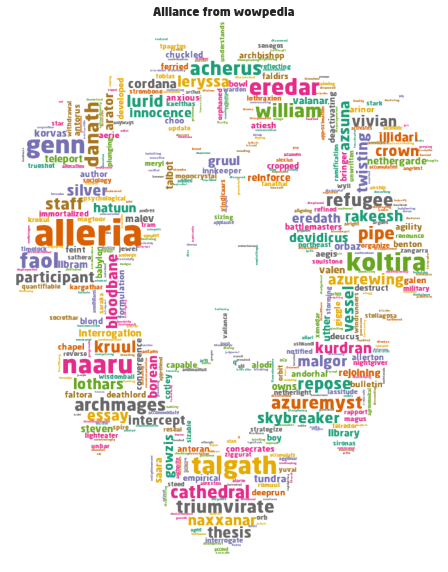

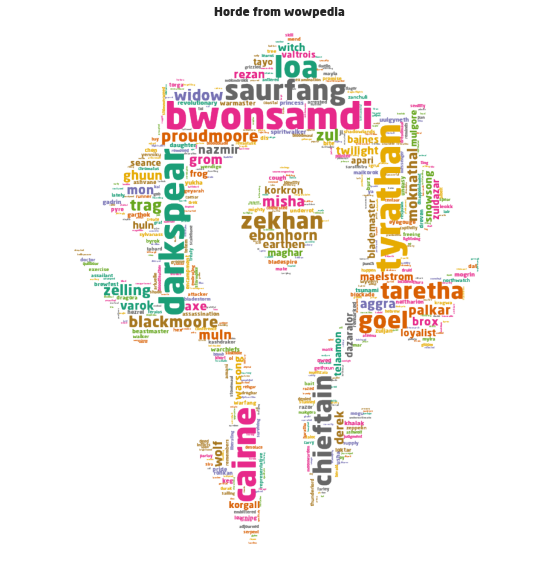

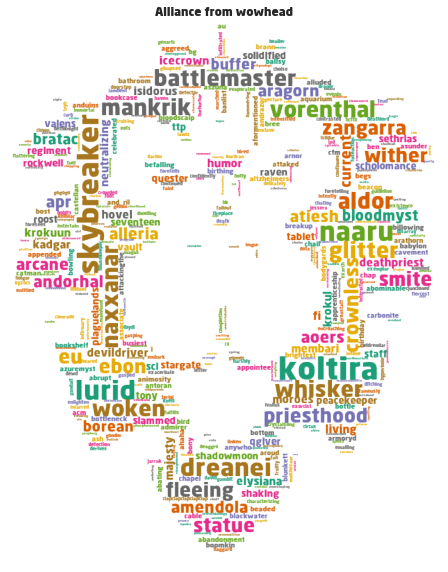

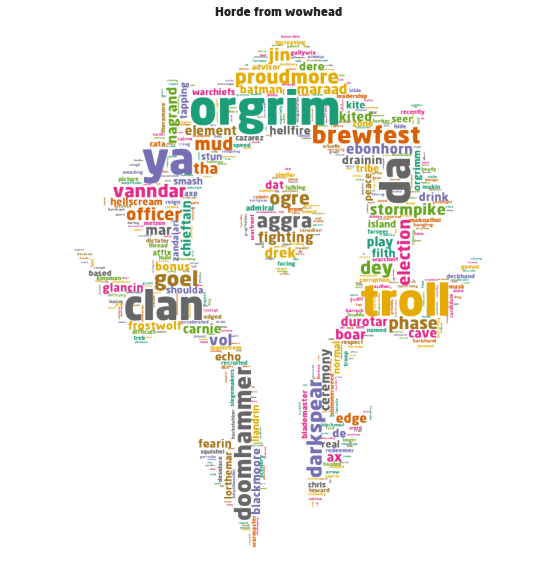

In [18]:
# define what to look into
attr_lookup = {
    'Faction': ['Alliance', 'Horde'],
}

# create wordclouds for attributes and sources
for source in ['wowpedia', 'wowhead']:
    PATH_RES = config.PATH_RES + source + '/'
    PATH_PLOTS = config.PATH_PLOTS + source + '/'
    for attr in attr_lookup:
        col = pickle.load(open(PATH_RES + attr + '_dict.json', 'rb'))
        for split in attr_lookup[attr]:
            # get mask if present
            maskpath = f'./store/masks/{split}.jpg'
            if not os.path.isfile(maskpath):
                maskpath = ''
            
            disp_wordcloud(
                split, col,
                title=f"{split} from {source}",
                maskpath=maskpath,
                figsize=(10, 10)
            )

Comparing these two wordclouds from wowpedia, we see that it is hard, if not impossible to spot a word that appears in both the Alliance and Horde wordcloud. Additionally, we see that chieftan is a rather large word in the Horde wordcloud, which makes sense since it's their version of a king. We can also see from the Alliance wordcloud that the title of Archmage is referenced a lot in the wikipedia pages, which aligns with the fact that Khadgar (which is/was an archmage) is one of the top connected characters. 

When we inspect the wordclouds from wowhead, we see that the words are very different, however some common words appear across the two sources. For Alliance "naaru", "skybreaker" and "bloodmyst" is mentioned in both wordclouds. For Horde we don't really see any common words, however some new very fitting words like "clan" and "troll" appear.


If you want to display other wordclouds, the code should be easily adjustable for you to do so, otherwise we refer to our webpage.

Some nice wordcloud comparisions can be seen between e.g. dead and alive from wowhead, where you can see that the words mainly comes from users trying to describe how to solo boss fights (words pet, kill, phase, killed etc.), these are still there for the deceased characters, but far less important. Another interesting wordcloud is for community 6, where the wordclouds for wowhead and wowpedia both match nearly perfectly with eachother, and these words also describe characteristics of the underlying community, which is the "Arakkoa" race for which "Skettis" is their capital, "Ikiss" is a king, "Sethekk" is one of their factions.

### Tool 4: Sentiment Analysis
The goal for this section is to produce a unidimensional sentiment score for some input text (be it a Wowhead comment, or a Wikipages quote). The idea is that performing this analysis will provide a new perspective on the data in our network.

For code see `Sentiment Analysis.iypnb`, this took a long while to run so we didn't include the code in this notebook (above 2 hours on a bad pc).

For the sentiment analysis part to be carried out, we needed some text to analyze first. Here, we chose to work with text from the scraped Wowhead comments, and with text from the extracted quotes from the Wikipages. We chose two different methods for performing the sentiment analysis:
* [VADER](https://github.com/cjhutto/vaderSentiment) is a dictionary- and rule-based approach to evaluating text sentiment. This means that under the hood, VADER has a lookup table which is used to assign sentiment scores to tokens individually. However, it has rules which alter the sentiment vaules based on negations, various punctuations, degree modifiers (e.g. *very* or *somewhat*), slang words, emojis, and much more. Furthermore, it should be noted that VADER is specifically tuned for text from social media. The VADER dictionary (or lexicon, as they call it) consists of about 7500 tokens. VADER produces several dimensions for sentiment, but the `compound` dimensions is stated as being the best unidimensional measure of sentiment (it is described as a "normalized, weighted composite score")
* [BERT (flairNLP)](https://github.com/flairNLP/flair). This approach is based on BERT (which is a deep learning technique for natural language modeling). It works by breaking down the input text into tokens, and assigning an embedding to every token. These embeddings are then combined in a manner which takes context/sequence into account (through *attention* mechanisms) and produces a single embedding for the entire input text. Classification can then be performed on this resulting vector, which turns it into a sentiment score (either positive/negative). What is noteworthy about this approach is its ability to capture long-range dependencies in sequences, and its large vocabulary size (this depends of the specific BERT variant, but is mostly in the scope of ~30K different tokens).


The VADER procedure is carried out as follows:
1. Break down input text into individual sentences (using previously described regex)
2. For every sentence, we pass it to VADER's `polarity_scores(...)` method and retrieve its `compound` score
3. Reduce all sentences to a single score by averaging them, and return it


The BERT procedure is carried out as follows:
1. Pass the input text directly to flair by creating a `flair.data.Sentence(...)` and subsequently calling `.predict(...)` on it
2. The prediction output is consists of a confidence in the range [0.5, 1], along with a binary class label {`NEGATIVE`, `POSITIVE`}. The confidence is mapped from [0.5, 1] to [0, 1] by subtracting 0.5 and multiplying the result by 2. It is then multiplied by -1 if the predicted class is `NEGATIVE`
3. Return the converted score

For both procedures, we reduce the sentiment scores for the individual text entities (Wowhead comments or Wikipage quotes) to a single character-level score by taking the mean of the scores for all comments/quotes that belong to the respective characters. 

In [19]:
vader_sentiment = SentimentIntensityAnalyzer()
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

char_comments = {
    os.path.basename(fn)[:-6].replace('_', ' '): [json.loads(l) for l in open(fn, 'r', encoding='utf-8')]
    for fn in glob('data/char_comments/*.njson')
}

# load pickled quote and comment sentiments (see "Sentiment Analysis.ipynb")
char_sentiments = pickle.load(open(config.PATH_RES + 'char_sentiments.pkl', 'rb'))
quote_sentiments = pickle.load(open(config.PATH_RES + 'quote_sentiments.pkl', 'rb'))

# unpack replies from comments and resolve common keys
for char in char_comments:
    char_comments[char] = sum(map(
        lambda c: [standardize_comment(c)] + [standardize_comment(r) for r in c.get('replies', [])],
        char_comments[char]
    ), [])

char_data = defaultdict(dict)
for char, comments in char_sentiments.items():
    for comment_id, vader_score, bert_score in comments:
        comment = next(c for c in char_comments[char] if c['id'] == comment_id)
        char_data[char][comment_id] = {
            'date': ciso8601.parse_datetime_as_naive(comment['date']),
            'rating': comment['rating'],
            'vader_sentiment': vader_score,
            'bert_sentiment': bert_score,
            'count': 1,
            'is_reply': comment['is_reply']
        }

df_sentiment = df[df.Name.apply(lambda n: n in char_sentiments)]
df_sentiment = df_sentiment[df_sentiment.Name.apply(lambda n: n in Gcc)]
df_sentiment['Community'] = df_sentiment.Name.apply(lambda n: com_names[next(i for i, C in enumerate(communities) if n in C)])

breakdown_lookup = {
    'faction': ('Faction', ['Horde', 'Alliance', 'Neutral']),
    'gender': ('Gender', ['Male', 'Female']),
    'status': ('Status', ['Alive', 'Deceased']),
    'community': ('Community', com_names)    
}

2021-12-08 12:11:35,458 loading file C:\Users\sap98\.flair\models\sentiment-en-mix-distillbert_4.pt


With the two procedures in place, we can look at how the models compare by sampling a couple of comments
*  `Great job Blizzard, Alliance finally have a faction boss to be proud of.`
    * BERT 1.00, VADER 0.80
    * The two methods seem to pretty clearly agree on this one
    
* `Rest in Peace, he had such potential as a Warchief, wish Blizz didn't kill him off so quickly.`
    * BERT -0.53, VADER 0.87
    * The two methods disagree on this one. We find this one a bit difficult to score ourselves, since there can be found arguments for both sides in the case of positive/negative scoring.
    
* `For Blood DKs, Anti-Magic Shell can be used to negate a stack of Black Scar from Mandible Slam at the moment.`
    * BERT 0.78, VADER -0.38
    * The methods seem to disagree on this one as well. If we were to assign this one a score, it would be quite neutral. The comment is simply stating a fact in regard to some abilities in the game.
    
* `Meryl is awesome and it's awesome that we're finally seeing him in-game.`
    * BERT 1.00, VADER 0.09
    * This example is pretty clearly of positive sentiment. However, it seems that only BERT picks up on this to a significant degree, which seems a bit odd, since VADER does have a lexicon entry for "awesome".

You can try sampling yourself:

In [20]:
for _ in range(1):
    comment = get_specific_comment('bert_sentiment', 0.75, char_data, char_comments)
    print('bert %.2f, vader %.2f\n%s' % comment)

bert 0.99, vader 0.15
I just want that staff!


It seems that the two sentiment analysis methods disagree at times. As such, it would be interesting to see how the VADER sentiment scores compare to the BERT scores on a bigger scale. To do this, we can take gather all the calculated scores for all comments and wikipedia quotes, and plot the following histograms:

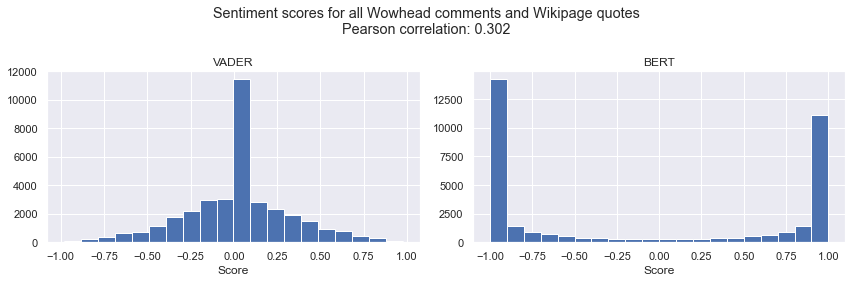

In [21]:
R = df_sentiment.apply(
    lambda x: 
    [[v[k] for v in char_data[x.Name].values()] for k in ['bert_sentiment', 'vader_sentiment']],
    axis=1
)
b = []
v = []
for r in R:
    b += r[0]
    v += r[1]
b += [q['bert_sentiment'] for q in quote_sentiments]
v += [q['vader_sentiment'] for q in quote_sentiments]


fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

ax[0].hist(v, bins=20)
ax[0].set_title('VADER')
ax[0].set_xlabel('Score')
ax[1].hist(b, bins=20)
ax[1].set_title('BERT')
ax[1].set_xlabel('Score')

corr = np.corrcoef([b,v])[0,1]
plt.suptitle('Sentiment scores for all Wowhead comments and Wikipage quotes\nPearson correlation: %.3f' % corr)
plt.tight_layout()
plt.show()

It is immediately apparent that the two methods produce significantly different scores for the text data we extracted. The VADER scores are very dense around 0, and get quite shallow towards the tails, with barely any scores when approaching the minimum and maximum of -1 and 1 respectively. Quite contrarily, the BERT scores are very heavily distributed towards the minimum and maximum, with more negative scores than negative in total. Very few BERT scores seem to lie in the middle of the continuum.

This difference in score distributions could probably stem from the following facts:
* Many out-of-lexicon tokens will lead to a high concentration of 0-scores for the VADER method. The BERT method has a bigger vocabulary, and out-of-vocabulary tokens do not have as big of an impact on this type of model.
* The BERT method uses a model which has been trained as a binary classification task. This could lead to a sharp decision boundary of confidence either being 0 or 1.
* Neither of the two methods are attuned to terms that arise from a fantasy universe such as the Warcraft universe. Words like "Dragon", "Death", "Monster", and "Thief" will affect the sentiment differently when the context of the Warcraft universe

It is important to have the mentioned differences in mind when comparing sentiment analysis results for the two methods.

We can also show sentiments of some specific groupings of characters, like we did for wordclouds, computed both for wowhead user comments and wowpedia character pages.

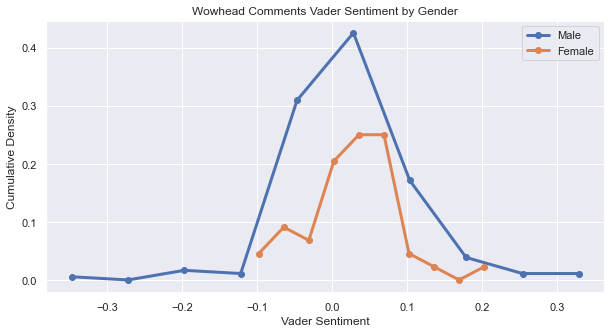

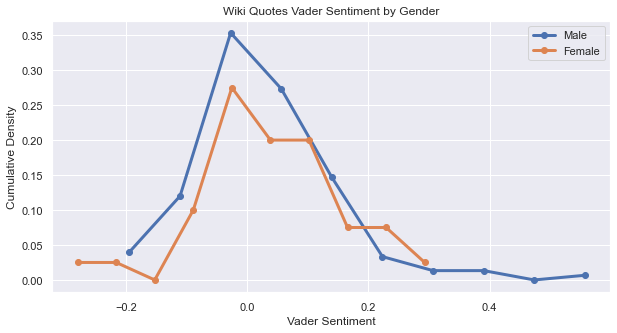

In [22]:
params = {
    'breakdown': 'gender',    # ['faction', 'gender', 'status', 'community'],
    'metric': 'vader_sentiment' # ['bert_sentiment', 'vader_sentiment'],
}
plot_comments_dist(df_sentiment, char_data, params, breakdown_lookup)
plot_quote_dist(df_sentiment, quote_sentiments, breakdown_lookup, params)

From these two distributions, we see that both the wowhead comments and wowpedia pages agree that Male and Female sentiment has a zero-mean distribution. As we would expect from the Vader distribution earlier.

### Tool 5: Time-Series Sentiment Analysis of Wowhead Comments
(The code for this section is defined in `Sentiment Analysis.ipynb`)

The comments also include a timestamp of when they were created. This means that we can plot the sentiment of comments as a time series, and try to reveal any potential trends in sentiment scores for characters over time.

We ended up with 4 different parameters for the configuration which controls how the plots are created.
* Breakdown
    * Groups the characters together by some characteristic. For instance, they can be grouped together by their defined `"Faction"` from Wikipages, or their `"Community"` which is derived from network characteristics)
    * `["Faction", "Gender", "Status", or "Community"]`
* Metric
    * A switch for which metric is being displayed for the comments. `"rating"` is the Wowhead comment rating
    * `["bert_sentiment", "vader_sentiment", "rating"]`
* Resample
    * Controls the date aggregation. Groups comments together by their date
    * `["Month", "Quarter", "Year"]`
* Replies
    * Whether or not to include comment replies in the calculations
    * `[true, false]`

Then we generated time series data for all combinations of parameters and saved it to a JSON file. The website then allows users to control the parameters through input components, which will swap out the data being presented based on which inputs are selected. 

A sample time series plot:

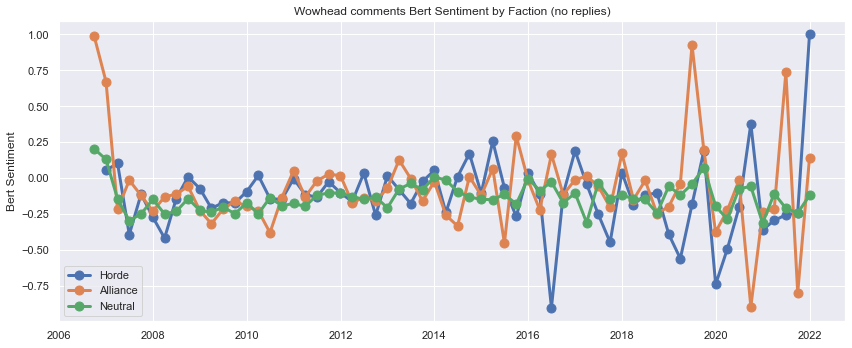

In [23]:
# define timeseries plotting parameters
P = {
    'breakdown': 'faction',     # ['faction', 'gender', 'status', 'community'],
    'metric': 'bert_sentiment', # ['bert_sentiment', 'vader_sentiment', 'rating'],
    'resample': 'Q',            # ['M', 'Q', 'Y'] for month, quarter, year
    'replies': False,           # [True, False]
}
X, Y = get_ts(df_sentiment, breakdown_lookup, char_sentiments, char_data, P)
plot_timeseries(P, breakdown_lookup, X, Y)

The above plot is created with a `Faction` breakdown, showing the `bert_sentiment` with `Q` (quarterly) date aggregation and excluding replies. It seems that the sentiment score for alliance and horde characters become quite volatile after around 2015. Also, it seems that alliance characters had high sentiment scores initially in 2006. If you want, it's possible to show different plots by simply changing the `P` dict. The possible values are shown in the in-line comments.

However, we are lacking some sense of signifiance in the plot. It may be true that the mean sentiment scores are more extreme, but, arguably, we need to know how many comments were included when generating the mean score. If very few comments were included in order to produce a high sentiment score, it becomes a lot less meaningful. To examine this, we created an accompanying time series plot to the one shown before.

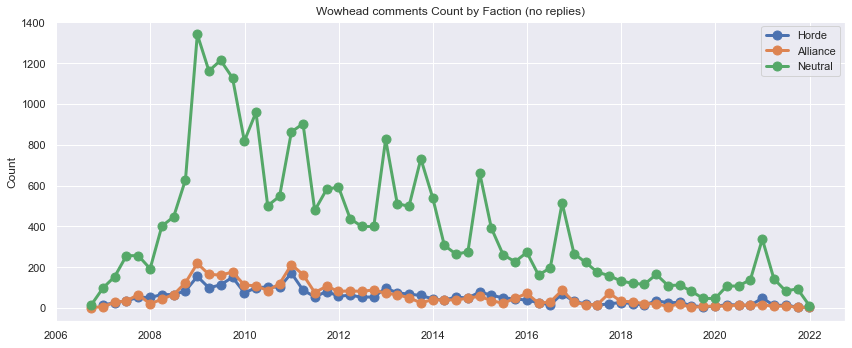

In [24]:
P['metric'] = 'count'
X, Y = get_ts(df_sentiment, breakdown_lookup, char_sentiments, char_data, P)
plot_timeseries(P, breakdown_lookup, X, Y)

And, as suspected, it seems that there are very few comments for alliance and horde characters during the volatile periods. When compared to the amount of neutral character comments, it seems that the amount of alliance and horde character comments is significantly lower. This could be because of the fact that a lot of the neutral characters are bosses in the game, and thus users are more eager to comment on these wowhead pages to explain in-game tactics or brag about getting good loot.


In conclusion, it should be noted that the time series plots lack the ability to illustrate the signifiance of the mean character sentiments. A possible solution could be to add error bars in order to portray either standard deviation, or some other measurement entirely which captures how many comments are in every date bin.

## 4. Discussion
Think critically about your creation
- What went well?
- What is still missing? 
- What could be improved?

**What went well**

In general every part of the project turned out quite well. The website ended up being far more interactive than initially expected, and is very easy to play around with - it is far better at comparing different wordclouds or attribute distributions than a plain python notebook, especially considering the graph interactions, where hovering over a node in the network visualization or the bars and points in the different plots provides the user with loads of information.

However, there were a lot of issues cleaning the character quotes from the raw wowpedia pages, which would've been nice to avoid. Since it used many regular expressions we also decided not to comment on the functionality of each and every one on them. The resulting character quotes turned out nicely and made it possible to do sentiment of the actual characters instead of their wikipages, which is far from the same, making it possible to do more comparisons of user comments and the characters themselves. 

Another thing to note is that the network is very small with only 261 nodes, and therefore the things that can be drawn from the analysis of the connections etc. in the network is unfortunately a bit limited.



**Missing**

One thing we did not include that we could've included was to investigate collocations and concordance in both the user comments from wowhead and on the wikipages and compared these. Another thing that is somewhat missing is adding some kind of weight of the edges in the network, which would allow us to do [backbone analysis](https://www.pnas.org/content/pnas/106/16/6483.full.pdf) of the network.

**Improvements**

If we were to improve the current work, there are multiple things that could be done (possibilities are somewhat endless here):
- improve character sentiment by adding more character quotes from the wowpedia pages
    - Some quote sections include linkings to collections of character quotes, from e.g. Warcraft 2, which could be downloaded and processed.
    - Manually find the different quoting pages on wowpedia and process these, adding quotes to major characters. 
    - Finding quotes from outside wowpedia, e.g. the Warcraft movie script or the different Warcraft books (probably behind paywalls)
        - Could lead to time series analysis of charcter sentiment, which could be compared to the sentiment time series of wowhead comments.
- expanding the network to not only include the [major character page on wowpedia](https://wowpedia.fandom.com/wiki/Major_characters)
- handle character nicknames
    - some characters have different nicknames that could also be handled in some way.
    - this is currently done when extracting character quotes in `extract_character_quotes.py`.
        - could be more elaborate and added for every processing step.
- Further investigations using `concordance` on the different texts.
    - Add it as an easily playfull tool on the website, such that the user could choose how to split the text and see concordance for each split.

## 5. Contributions
Who did what? You should write (just briefly) which group member was the main responsible for which elements of the assignment. 

**Main responsibilities**
* Janus Ivert Johansen, s173917
    * Setting up the website 
    * Wordcloud masks
    * Network visualization
    * Degree Distributions
* Lucas Alexander Sørensen, s174461
    * Downloading comments from wowhead
    * Sentiment Analysis (Bert and VADER)
    * Timeseries sentiment
* Simon Amtoft Pedersen, s173936
    * Downloading & cleaning data
    * Extracting character quotes from wowpedia character pages
    * Words that matter! (tf-idf, concordance etc.)
    * Wordclouds
    * Centrality Measures & Assortativity
    * Communities